# SSD-Caffe face detector training

(In case anything goes wrong)

In [0]:
#!kill -9 -1

In [3]:
!ls

sample_data


## Build SSD-Caffe

(It takes about 30 minutes)

In [0]:
print "Install deps and gcc"

with open('/etc/apt/sources.list') as f:
  txt = f.read()
with open('/etc/apt/sources.list', 'w') as f:
  f.write(txt.replace('# deb-src','deb-src'))
  
t=!apt update
t=!apt build-dep caffe-cuda
t=!apt install g++-5

t=!update-alternatives --remove-all gcc 
t=!update-alternatives --remove-all g++
t=!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
t=!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20
t=!update-alternatives --install /usr/bin/cc cc /usr/bin/gcc 30
t=!update-alternatives --set cc /usr/bin/gcc
t=!update-alternatives --install /usr/bin/c++ c++ /usr/bin/g++ 30
t=!update-alternatives --set c++ /usr/bin/g++

print "Get boost"

t=!wget https://dl.bintray.com/boostorg/release/1.67.0/source/boost_1_67_0.tar.bz2
t=!tar --bzip2 -xf boost_1_67_0.tar.bz2

print "Compile boost"

t=!cd boost_1_67_0 && ./bootstrap.sh --exec-prefix=/usr/local --with-libraries=system,filesystem,regex,thread,python \
--with-python-version=2.7 --with-python-root=/usr
t=!cd boost_1_67_0 && ./b2 install

print "Clone SSD-Caffe and configure it"

t=!git clone https://github.com/weiliu89/caffe.git && cd caffe && git checkout ssd
  
with open('caffe/Makefile.config.example') as f:
  config = f.read()
comment = ['CUDA_DIR := /usr/local/cuda', 
           'BLAS := open']
uncomment = ['# CUDA_DIR := /usr', 
             '# BLAS := atlas', 
             '# OPENCV_VERSION := 3', '# WITH_PYTHON_LAYER := 1'] #
replace = [('INCLUDE_DIRS := $(PYTHON_INCLUDE) /usr/local/include',
            'INCLUDE_DIRS := $(PYTHON_INCLUDE) /usr/local/include /usr/include/hdf5/serial /usr/local/lib/python2.7/dist-packages/numpy/core/include/'), 
           ('LIBRARY_DIRS := $(PYTHON_LIB) /usr/local/lib /usr/lib',
            'LIBRARY_DIRS := $(PYTHON_LIB) /usr/local/lib /usr/lib /usr/lib/x86_64-linux-gnu/hdf5/serial')]
for c in uncomment:
  config = config.replace(c, c[2:])
for c in comment:
  config = config.replace(c, '# '+c)
for c1,c2 in replace:
  config = config.replace(c1, c2)
with open('caffe/Makefile.config', 'w') as f:
  f.write(config)
  
with open('caffe/Makefile') as f:
  mfile = f.read()
with open('caffe/Makefile', 'w') as f:
  f.write(mfile.replace('-isystem','-I'))
  
with open('/usr/include/x86_64-linux-gnu/c++/5/bits/c++config.h') as f:
  txt = f.read()
with open('/usr/include/x86_64-linux-gnu/c++/5/bits/c++config.h', 'w') as f:
  f.write(txt.replace('/* #undef _GLIBCXX_USE_C99_MATH */',
                      '/* #undef _GLIBCXX_USE_C99_MATH */\n#define  _GLIBCXX_USE_C99_MATH  1'))
  
print "Make Caffe"

#t=!cd caffe && make -j8 && make pycaffe && make test -j8 && make distribute
t=!cd caffe && make -j8 && make pycaffe && make distribute
print '\n'.join(t[-10:])

t=!echo /usr/local/lib >> /etc/ld.so.conf && ldconfig
t=!echo /content/caffe/distribute/lib >> /etc/ld.so.conf && ldconfig

print "DONE"

Install deps and gcc
Get boost
Compile boost


/content/boost_1_67_0/libs/predef/check/../tools/check/predef.jam:46: Unescaped special character in argument $(language)::$(expression)
Performing configuration checks

    - default address-model    : 64-bit
    - default architecture     : x86
    - symlinks supported       : yes
    - has_icu builds           : no
    - lockfree boost::atomic_flag : yes

Component configuration:

    - atomic                   : not building
    - chrono                   : not building
    - container                : not building
    - context                  : not building
    - contract                 : not building
    - coroutine                : not building
    - date_time                : not building
    - exception                : not building
    - fiber                    : not building
    - filesystem               : building
    - graph                    : not building
    - graph_parallel           : not building
    - iostreams                : not building
    - locale       

## Clone repo

In [0]:
#!rm -rf MobilenetSSDFace

In [0]:
t=!git clone https://github.com/BeloborodovDS/MobilenetSSDFace.git

Configure for current machine

In [0]:
with open('MobilenetSSDFace/Makefile') as f:
  txt = f.read()
  
replace = [('cur_dir := "$(shell pwd)"',
            'cur_dir := /content/MobilenetSSDFace'), 
           ('data_dir := /home/dmitrii/Work/Datasets',
            'data_dir := /content/Datasets'), 
           ('lmdb_pyscript := /opt/movidius/ssd-caffe/scripts/create_annoset.py',
            'lmdb_pyscript := /content/caffe/scripts/create_annoset.py'), 
           ('caffe_exec := /opt/movidius/ssd-caffe/build/tools/caffe', 
            'caffe_exec := /content/caffe/build/tools/caffe'), 
           ('python3 $(lmdb_pyscript)',
            'export PYTHONPATH=${PYTHONPATH}:/content/caffe/python && python2 $(lmdb_pyscript)'), 
           ('python3', 'python2')] 

for a,b in replace:
  txt = txt.replace(a,b)
  
with open('MobilenetSSDFace/Makefile', 'w') as f:
  f.write(txt)

## Get data

In [0]:
#!rm -rf Datasets

If WIDER_train.zip or WIDER_val.zip load in 0 seconds, run the cell below again

In [5]:
!cd MobilenetSSDFace && make wider_load

mkdir -p -v /content/Datasets/WIDERfacedet && cd /content/Datasets/WIDERfacedet && \
wget --quiet --save-cookies cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=0B6eKvaijfFUDQUUwd21EckhUbWs" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > confirm.txt && \
wget --load-cookies cookies.txt "https://docs.google.com/uc?export=download&confirm=`cat confirm.txt`&id=0B6eKvaijfFUDQUUwd21EckhUbWs" -O WIDER_train.zip && \
wget --quiet --save-cookies cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=0B6eKvaijfFUDd3dIRmpvSk8tLUk" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > confirm.txt && \
wget --load-cookies cookies.txt "https://docs.google.com/uc?export=download&confirm=`cat confirm.txt`&id=0B6eKvaijfFUDd3dIRmpvSk8tLUk" -O WIDER_val.zip && \
wget http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip -O wider_face_split.zip && \
rm -

In [0]:
t=!cd MobilenetSSDFace && make fddb_load

In [0]:
t=!cd MobilenetSSDFace && make datasets

In [8]:
t=!cd MobilenetSSDFace && make lmdb
print '\n'.join(t[-2:])

Makefile:58: recipe for target 'wider_xml' failed
make: *** [wider_xml] Error 1


## Test Caffe

In [9]:
import sys
import os
caffe_path = !cd caffe/python && pwd
sys.path.insert(0, caffe_path[0])  
import caffe

import cv2
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

from caffe.proto.caffe_pb2 import SolverParameter
import google.protobuf.text_format as txtf

ImportError: ignored

In [0]:
caffe.set_mode_gpu()
net = caffe.Net('MobilenetSSDFace/models/ssd_voc/deploy.prototxt',
                'MobilenetSSDFace/models/ssd_voc/MobileNetSSD_deploy.caffemodel', 
                caffe.TEST)
%timeit net.forward()

10 loops, best of 3: 71.5 ms per loop


## Test SSD detector

In [0]:
class_labels = ('background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 
                'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
                'sofa', 'train', 'tvmonitor')

def transform_input(img, transpose=True, dtype=np.float32):
    inpt = cv2.resize(img, (300,300))
    inpt = inpt - 127.5
    inpt = inpt / 127.5
    inpt = inpt.astype(dtype)
    if transpose:
        inpt = inpt.transpose((2, 0, 1))
    return inpt

def transform_output(img, output):
    h,w = img.shape[:2] 
    boxes = (output['detection_out'][0,0,:,3:7] * np.array([w, h, w, h])).astype(int)
    classes = output['detection_out'][0,0,:,1].astype(int)
    confidence = output['detection_out'][0,0,:,2]
    if (len(confidence)==1) and (confidence[0]<0):
        return [],[],[]
    return boxes, classes, confidence

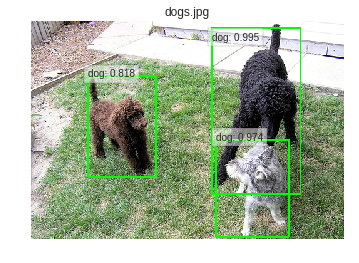

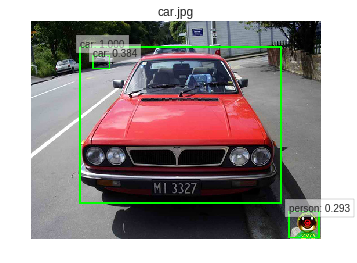

In [0]:
for fn in ['dogs.jpg','car.jpg']:
    img = cv2.imread('MobilenetSSDFace/images/'+fn)
    
    inpt = transform_input(img)
    net.blobs['data'].data[...] = inpt
    output = net.forward() 
    boxes, classes, confidence = transform_output(img, output)

    for box, cls, conf in zip(boxes, classes, confidence):
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
        txt = class_labels[int(cls)]+': %.3f' % float(conf)
        plt.text(max(box[0],30), max(box[1],30), txt, bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
    plt.imshow(img[:,:,::-1])
    plt.title(fn)
    plt.show()

## Mount Google Drive

In [0]:
t=!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
t=!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
t=!apt-get update -qq 2>&1 > /dev/null
t=!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!mkdir -p drive/CaffeFace/snapshots

In [0]:
!ls drive/CaffeFace/snapshots

## Generate nets

In [0]:
t=!cd MobilenetSSDFace && export PYTHONPATH=${PYTHONPATH}:/content/caffe/python && make face_model_full
print(t[-1])

Model complete


## Train

### LR Test

In [0]:
with open('MobilenetSSDFace/train_files/solver_train_full.prototxt') as f:
  params = SolverParameter()
  txtf.Merge(f.read(), params)
  
params.solver_mode = 1 #set GPU mode
params.debug_info = False
params.snapshot_prefix = "/content/drive/CaffeFace/snapshots/a2_lrtest"
params.base_lr = 1e-6
params.regularization_type = "L1"
params.weight_decay = 0.00005
params.snapshot = 85
params.lr_policy = "step"
params.gamma = np.sqrt(10)
params.stepsize = 170
params.max_iter = 1700
del params.stepvalue[:]
print params

with open('MobilenetSSDFace/train_files/solver_train_full.prototxt', 'w') as f:
  f.write(txtf.MessageToString(params))

In [0]:
!cd MobilenetSSDFace && make train_full

### Train

In [0]:
with open('MobilenetSSDFace/train_files/solver_train_full.prototxt') as f:
  params = SolverParameter()
  txtf.Merge(f.read(), params)
  
params.solver_mode = 1 #set GPU mode
params.debug_info = False
params.snapshot_prefix = "/content/drive/CaffeFace/snapshots/a2"
params.base_lr = 3e-4
params.regularization_type = "L1"
params.weight_decay = 0.00005
params.snapshot = 500
params.lr_policy = "exp"
params.gamma = 0.9998
params.max_iter = 15000
del params.stepvalue[:]
print params

with open('MobilenetSSDFace/train_files/solver_train_full.prototxt', 'w') as f:
  f.write(txtf.MessageToString(params))

In [0]:
!cd MobilenetSSDFace && make train_full

### Resume from snapshot

In [0]:
!echo /content/drive/CaffeFace/snapshots/a2_iter_4500.solverstate > MobilenetSSDFace/train_files/snapshot.txt
!cat MobilenetSSDFace/train_files/snapshot.txt

In [0]:
!cd MobilenetSSDFace && make resume_full